In [1]:
import requests
import layoutparser as lp

In [2]:
r = requests.get("https://cac.annauniv.edu/PhpProject1/aidetails/afug_2017_fu/01.%20B.E.EEE.pdf", verify=False)
with open("test.pdf", 'wb') as fp:
    fp.write(r.content)

/home/iamharish/lastpage-syllabus-parser/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cac.annauniv.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [3]:
pdf_tokens, pdf_images = lp.load_pdf("test.pdf", load_images=True)

In [4]:
model = lp.Detectron2LayoutModel(
    config_path = "./outputs/lastpage/fast_rcnn_R_50_FPN_3x/config.yaml",
    model_path = "./outputs/lastpage/fast_rcnn_R_50_FPN_3x/model_final.pth",
    extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # <-- Only output high accuracy preds
)

In [5]:
layout = model.detect(pdf_images[24])

/home/iamharish/lastpage-syllabus-parser/venv/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


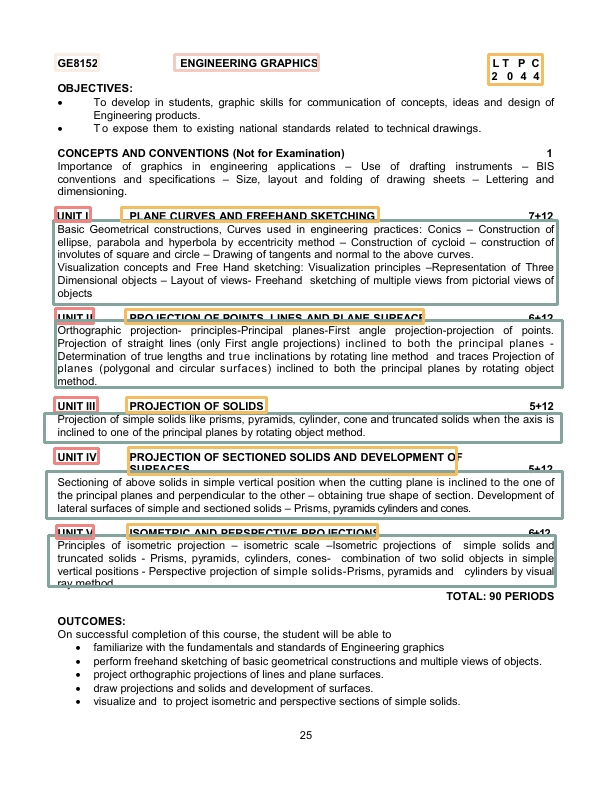

In [6]:
lp.draw_box(pdf_images[24], layout)

In [7]:
layout_data = layout.to_dataframe()
layout_data

,x_1,y_1,x_2,y_2,block_type,type,score
0,48.410271,535.778931,555.133301,586.890381,rectangle,5,0.999931
1,174.830582,54.898022,318.526337,70.695145,rectangle,4,0.999915
2,55.279491,308.547577,93.190590,323.605804,rectangle,6,0.999832
3,53.142029,220.702362,557.617004,304.494385,rectangle,5,0.999564
4,55.981758,320.822601,562.117920,387.616913,rectangle,5,0.999551
5,55.151070,207.366806,90.569641,221.999435,rectangle,6,0.999528
6,54.027691,397.413666,97.143112,412.152130,rectangle,6,0.999493
7,44.425983,413.417755,561.007996,442.559509,rectangle,5,0.999436
8,127.677864,524.677917,377.266815,538.544067,rectangle,7,0.999435
9,56.708004,525.008240,93.564705,538.125671,rectangle,6,0.999418


#### Sort Page Contents Based on Relative Positions

In [9]:
page_contents = {} 

for page_index in [22, 23, 24]: # Pages with Subject-Level Data 
    syllabus_items = model.detect(pdf_images[page_index])
    
    page_syllabus_tokens = []
    for syllabus_item in syllabus_items:
        syllabus_tokens = pdf_tokens[page_index].filter_by(syllabus_item, center=True)
        page_syllabus_tokens.append(syllabus_tokens)
        
    page_syllabus_tokens = sorted(page_syllabus_tokens, key=lambda tokens: min([ele.id for ele in tokens]))
    # Sort them using PDF Token Indices 
    
    page_contents[page_index] = [" ".join(syllabus_tokens.get_texts()) for syllabus_tokens in page_syllabus_tokens]



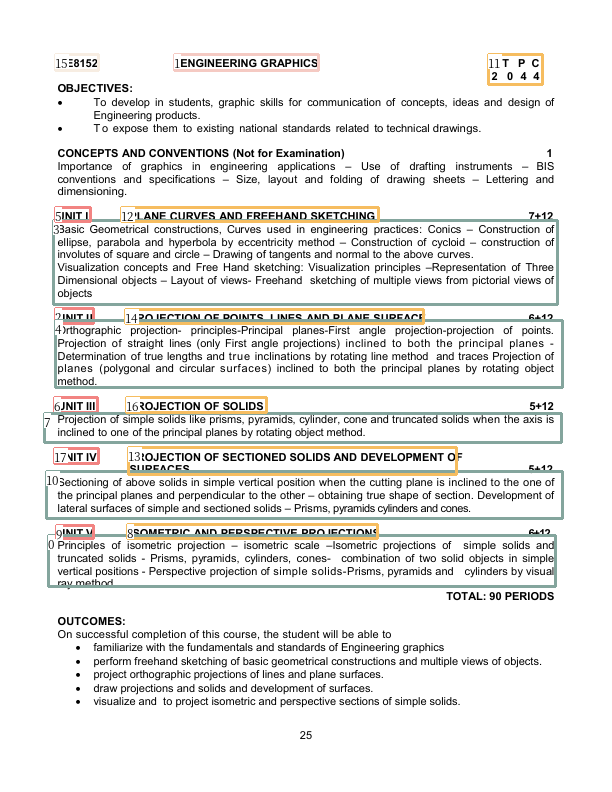

In [17]:
visualize = lp.draw_box(pdf_images[page_index], syllabus_items, show_element_id=True, id_font_size=12)
visualize

In [18]:
import pandas as pd 

(pd
 .DataFrame(tuple(page_contents.items()), 
             columns=['page_index', 'annotations'])
 .explode('annotations')
 .reset_index(drop=True)
)[:10]

,page_index,annotations
0,22,GE8151
1,22,PROBLEM SOLVING AND PYTHON PROGRAMMING
2,22,L T P C 3 0 0 3
3,22,UNIT I
4,22,ALGORITHMIC PROBLEM SOLVING
5,22,"Algorithms, building blocks of algorithms (sta..."
6,22,UNIT II
7,22,"DATA, EXPRESSIONS, STATEMENTS"
8,22,Python interpreter and interactive mode; value...
9,23,UNIT III
